In [14]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()
import MathOptInterface as MOI
import Ipopt 
import FiniteDiff
import ForwardDiff as FD
import Convex as cvx 
import ECOS
import MeshCat as mc
import Distributions
import Random
using LinearAlgebra
using Plots
using Random
using JLD2
using Test
using CSV
using DataFrames
using ProgressMeter


  Activating environment at `c:\Users\AiPEX-WS4\Documents\AiPEX-Projects\warmstarting_NLPs\JL_presolves\Project.toml`


In [2]:
include(joinpath(@__DIR__, "utils","fmincon.jl"))
include(joinpath(@__DIR__, "utils","cartpole_animation.jl"))

animate_cartpole (generic function with 1 method)

### Dynamics 

In [3]:
# cartpole 
function dynamics(params::NamedTuple, x::Vector, u)
    # cartpole ODE, parametrized by params. 

    # cartpole physical parameters 
    mc, mp, l = params.mc, params.mp, params.l
    g = 9.81
    
    q = x[1:2]
    qd = x[3:4]

    s = sin(q[2])
    c = cos(q[2])


    H = [mc+mp mp*l*c; mp*l*c mp*l^2]
    C = [0 -mp*qd[2]*l*s; 0 0]
    G = [0, mp*g*l*s]
    B = [1, 0]

    qdd = -H\(C*qd + G - B*u[1])
    xdot = [qd;qdd]
    return xdot 

end

function hermite_simpson(params::NamedTuple, x1::Vector, x2::Vector, u, dt::Real)::Vector
    # TODO: input hermite simpson implicit integrator residual 
     x_mid = 0.5(x1 + x2) + (dt/8) * (dynamics(params, x1, u) - dynamics(params, x2, u))
     res = x1 + (dt/6) * (dynamics(params, x1, u) + 4*dynamics(params, x_mid, u) + dynamics(params, x2, u)) - x2
     return res
end

hermite_simpson (generic function with 1 method)

### Indexing and Constraints

In [4]:
function create_idx(nx,nu,N)
    # This function creates some useful indexing tools for Z 
    # x_i = Z[idx.x[i]]
    # u_i = Z[idx.u[i]]
    
    # Feel free to use/not use anything here.
    
    # our Z vector is [x0, u0, x1, u1, …, xN]
    nz = (N-1) * nu + N * nx # length of Z 
    x = [(i - 1) * (nx + nu) .+ (1 : nx) for i = 1:N]
    u = [(i - 1) * (nx + nu) .+ ((nx + 1):(nx + nu)) for i = 1:(N - 1)]
    
    # constraint indexing for the (N-1) dynamics constraints when stacked up
    c = [(i - 1) * (nx) .+ (1 : nx) for i = 1:(N - 1)]
    nc = (N - 1) * nx # (N-1)*nx 
    
    return (nx=nx,nu=nu,N=N,nz=nz,nc=nc,x= x,u = u,c = c)
end

function cartpole_cost(params::NamedTuple, Z::Vector)::Real
    idx, N, xg = params.idx, params.N, params.xg
    Q, R, Qf = params.Q, params.R, params.Qf
    
    # TODO: input cartpole LQR cost 
    J = 0 

    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]]
       
        J += 0.5*(xi-xg)'*Q*(xi-xg) + 0.5*ui'*R*ui
    end
    
    # dont forget terminal cost 
    xN = Z[idx.x[N]]
    J += 0.5*(xN-xg)'*Qf*(xN-xg)
    return J 
end

function cartpole_dynamics_constraints(params::NamedTuple, Z::Vector)::Vector
    idx, N, dt = params.idx, params.N, params.dt
    
    # TODO: create dynamics constraints using hermite simpson 

    # create c in a ForwardDiff friendly way (check HW0)
    c = zeros(eltype(Z), idx.nc)
    
    for i = 1:(N-1)
        xi = Z[idx.x[i]]
        ui = Z[idx.u[i]] 
        xip1 = Z[idx.x[i+1]]
        
        # TODO: hermite simpson 
        c[idx.c[i]] = hermite_simpson(params, xi, xip1, ui, dt)
    end
    return c 
end

function cartpole_equality_constraint(params::NamedTuple, Z::Vector)::Vector
    N, idx, xic, xg = params.N, params.idx, params.xic, params.xg 
    
    
    # TODO: return all of the equality constraints 

    
    return [Z[idx.x[1]] - xic; Z[idx.x[end]] - xg; cartpole_dynamics_constraints(params, Z)] 
end

    


cartpole_equality_constraint (generic function with 1 method)

## NLP Formulation

In [5]:
function solve_cartpole_swingup(σ, z0=nothing; verbose=true)
    
    # problem size 
    nx = 4 
    nu = 1 
    dt = 0.1
    tf = 3.0
    t_vec = 0:dt:tf 
    N = length(t_vec)
    
    # LQR cost 
    Q = 1*diagm(ones(nx))
    R = 0.1*diagm(ones(nu))
    Qf = 10*diagm(ones(nx))
    
    # indexing 
    idx = create_idx(nx,nu,N)
    
    # initial and goal states 
    # xic = [0, 0, 0, 0]
    xic = [σ[1], σ[2], 0, 0]
    xg = [0, pi, 0, 0]
    
    # load all useful things into params 
    params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 1.0, mp = 0.2, l = 0.5)
    
    # TODO: primal bounds 
    x_l = fill(-Inf, idx.nz)
    x_u = fill(Inf, idx.nz)
    
    # for i = 1:(N-1)
    #     x_l[idx.u[i]] .= -20
    #     x_u[idx.u[i]] .= 20
    # end

    
    # inequality constraint bounds (this is what we do when we have no inequality constraints)
    c_l = zeros(0)
    c_u = zeros(0)
    function inequality_constraint(params, Z)
        return zeros(eltype(Z), 0)
    end
    
    # initial guess 
    if z0 == nothing # if no initial guess is provided, use a straight line between xic and xg
        z0 = zeros(idx.nz)
        interpolated_x = interpolate_pose(xic, xg, N)
        for i = 1:N
            z0[idx.x[i]] = interpolated_x[i]
        end
        z0 += 0.001*randn(idx.nz)
    else # if an initial guess is provided, use it plus noise
        z0 += 0.001*randn(idx.nz)
    end
    
    # diff type
    diff_type = :auto 
    
        
    Z, obj, solve_time_sec, term_status = fmincon(cartpole_cost,cartpole_equality_constraint,inequality_constraint,
                x_l,x_u,c_l,c_u,z0,params, diff_type;
                tol = 1e-6, c_tol = 1e-6, max_iters = 10_000, verbose = verbose)


    # pull the X and U solutions out of Z 
    X = [Z[idx.x[i]] for i = 1:N]
    U = [Z[idx.u[i]] for i = 1:(N-1)]
    
    return X, U, obj, solve_time_sec, term_status, t_vec, params 
end


solve_cartpole_swingup (generic function with 2 methods)

## Interpolated initialization

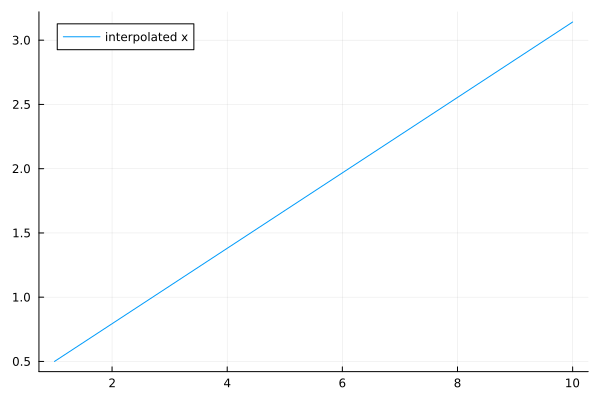

In [6]:
function interpolate_pose(x0::Vector, x1::Vector, N)
    X = [x0 + (x1 - x0) * i/(N-1) for i = 0:(N-1)]
    return X
end

x0 = [0.0, 0.5, 0.0, 0.0]
x1 = [0.0, pi, 0.0, 0.0]
interpolated_x = interpolate_pose(x0, x1, 10)
Xm = hcat(interpolated_x...)
display(plot(Xm'[:,2], label="interpolated x"))

## Solve cartpole for a single parameter sample

---------checking dimensions of everything----------
---------all dimensions good------------------------
---------diff type set to :auto (ForwardDiff.jl)----
---------testing objective gradient-----------------
---------testing constraint Jacobian----------------
---------successfully compiled both derivatives-----
---------IPOPT beginning solve----------------------

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:    19712
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian...

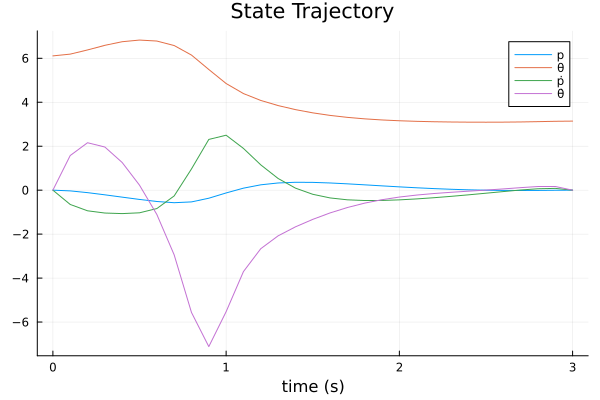

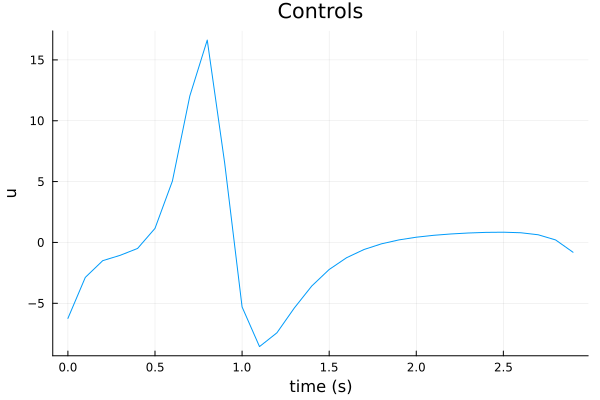

UndefVarError: UndefVarError: len not defined

In [7]:
σ = [0.0, deg2rad(350), 0, 0]

X, U, obj, solve_time_sec, term_status, t_vec, params = solve_cartpole_swingup(σ; verbose=true)

# --------------testing------------------

Xm = hcat(X...)
Um = hcat(U...)

# --------------plotting-----------------
display(plot(t_vec, Xm', label = ["p" "θ" "ṗ" "θ̇"], xlabel = "time (s)", title = "State Trajectory"))
display(plot(t_vec[1:end-1],Um',label="",xlabel = "time (s)", ylabel = "u",title = "Controls"))
len(t_vec)



In [8]:
display(animate_cartpole(X, 0.1))
# animate_cartpole(X, 0.05)


┌ Info: Listening on: 127.0.0.1:8700, thread id: 1
└ @ HTTP.Servers C:\Users\AiPEX-WS4\.julia\packages\HTTP\sJD5V\src\Servers.jl:382
┌ Info: MeshCat server started. You can open the visualizer by visiting the following URL in your browser:
│ http://127.0.0.1:8700
└ @ MeshCat C:\Users\AiPEX-WS4\.julia\packages\MeshCat\0RCA3\src\visualizer.jl:64


MeshCat.DisplayedVisualizer(MeshCat.CoreVisualizer(MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), UInt8[0x83, 0xa7, 0x6f, 0x70, 0x74, 0x69, 0x6f, 0x6e, 0x73, 0x82  …  0x5f, 0x61, 0x6e, 0x69, 0x6d, 0x61, 0x74, 0x69, 0x6f, 0x6e], Dict{String, MeshCat.SceneTrees.SceneNode}("meshcat" => MeshCat.SceneTrees.SceneNode(nothing, nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}("pole" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x70, 0x6f, 0x6c, 0x65], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "b" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x62], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "cart" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x63, 0x61, 0x72, 0x74], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()), "a" => MeshCat.SceneTrees.SceneNode(UInt8[0x83, 0xa6, 0x6f, 0x62, 0x6a, 0x65, 0x63, 0x74, 0x84, 0xaa  …  0x2f, 0x6d, 0x65, 0x73, 0x68, 0x63, 0x61, 0x74, 0x2f, 0x61], nothing, Dict{String, Vector{UInt8}}(), nothing, Dict{String, MeshCat.SceneTrees.SceneNode}()))))), Set{HTTP.WebSockets.WebSocket}(), ip"127.0.0.1", 8700, HTTP.Servers.Server{HTTP.Servers.Listener{Nothing, Sockets.TCPServer}}(HTTP.Servers.Listener{Nothing, Sockets.TCPServer}(Sockets.InetAddr{Sockets.IPv4}(ip"127.0.0.1", 8700), "127.0.0.1", "8700", nothing, Sockets.TCPServer(Base.Libc.WindowsRawSocket(0x00000000000009ac) active)), nothing, Set{HTTP.Connections.Connection}(), Task (runnable) @0x00000000cddd8e20, ReentrantLock(nothing, Base.GenericCondition{Base.Threads.SpinLock}(Base.InvasiveLinkedList{Task}(nothing, nothing), Base.Threads.SpinLock(0)), 0))))

## Solve the DIRCOL NLP for a parameter set

In [9]:
## Define upper and lower bounds of the parameters for the Paramaetric Optimal Control Problem
# using the xic of the cartpole
using Random, Distributions, CSV, DataFrames, ProgressMeter
Random.seed!(123)

N = 50 # number of samples
# σ_lower = [-1.0, 0]
# σ_upper = [1.0, 2*pi]
σ_lower = [-0.5, -pi/2]
σ_upper = [0.5, pi/2]

# Randomly sample the iid parameters uniformly from the given bounds
d = Product(Uniform.(σ_lower, σ_upper))
σ_samples = rand(d, N)
σ_samples = eachcol(σ_samples)

# Solve the NLP for the parameter sample set
df = DataFrame(params = Vector{Vector{Float64}}(), X=Vector{Vector{Vector{Float64}}}(), U=Vector{Vector{Vector{Float64}}}(), obj = Float64[], solve_time_sec = Float64[], term_status = MOI.TerminationStatusCode[])

p = Progress(N, 1)
i = 1
for σ in σ_samples
    next!(p)
    # z0 = 0.001*randn(idx.nz)
    X, U, obj, solve_time_sec, term_status, t_vec, params = solve_cartpole_swingup(σ, verbose=false)

    # if i % 10 == 0
    #     println("Sample: ", i)
    #     println("------------------")
    #     println("σ: ", σ)
    #     println("Objective Value: ", obj)
    #     println("Termination Status Code: ", term_status)
    #     println("Solve Time: ", solve_time_sec, "s")
    #     println("")
    # end

    push!(df, [σ, X, U, obj, solve_time_sec, term_status])
    i += 1
end



In [10]:

CSV.write("../data/presolves/cartpole_DIRCOL_50.csv", df)

UndefVarError: UndefVarError: df not defined

## Load in the Warmstarts and Solve for the Refined Trajectories

In [26]:
using CSV

df = DataFrame(CSV.File("../data/warmstart_trajectories/cartpole_100_no_reg.csv"))
Z_warmstart_str = df.Z_warmstart[1]
@show Z_warmstart_str
Z_warmstart_str = replace(Z_warmstart_str, r"\n" => "")
Z_warmstart = eval(Meta.parse(Z_warmstart_str))
# # Function to convert the string representation to a 2D array
# function convert_to_2d_array(str::String)
#     # Remove the brackets and newline characters
#     clean_str = replace(str, r"[\[\]\n]" => "")
#     # Split the string into individual numbers
#     num_strs = split(clean_str)
#     # Convert the numbers to Float64
#     nums = parse.(Float64, num_strs)
#     # Reshape the flat array into a 2D array
#     num_rows = count(x -> x == '\n', str) + 1
#     num_cols = length(nums) ÷ num_rows
#     return reshape(nums, num_cols, num_rows)'
# end

# X_warmstart = convert_to_2d_array(X_warmstart_str)
# X_warmstart = X_warmstart'
# X_warmstart = [X_warmstart[:, i] for i in 1:size(X_warmstart, 2)]
# @show size(X_warmstart[1])

Z_warmstart_str = "[ 5.76977655e-02 -6.55383527e-01 -2.37332657e-03 -3.86959240e-02\n  1.03115587e+01  6.97668940e-02 -6.34717405e-01  8.70344639e-01\n -2.15016782e-01  2.92332959e+00  1.81766272e-01 -5.52116215e-01\n  1.09422505e+00  1.65357128e-01 -5.28564930e-01  2.34429732e-01\n -4.96717989e-01  9.31437969e-01  1.44855762e+00 -6.16625452e+00\n  3.17943156e-01 -3.85926366e-01  2.53881276e-01  3.38443923e+00\n -1.16806993e+01  2.46156797e-01  1.77290887e-01 -7.84040868e-01\n  5.13959360e+00 -9.46008682e+00  1.68149680e-01  7.38878012e-01\n -1.40235996e+00  5.09537029e+00 -2.49143505e+00  7.78727233e-03\n  1.11380720e+00 -1.48532796e+00  4.55793428e+00  2.42794538e+00\n -8.45712870e-02  1.68402004e+00 -1.37142050e+00  3.84843302e+00\n  4.36322165e+00 -3.35493147e-01  1.95691061e+00 -9.01889145e-01\n  3.36596274e+00  4.16035175e+00 -2.91624248e-01  2.19728494e+00\n -4.69809592e-01  2.92492151e+00  2.41338348e+00 -2.94029027e-01\n  2.56135058e+00 -2.89715916e-01  2.47431135e+00  1.14882

1×154 Matrix{Float64}:
 0.0576978  -0.655384  -0.00237333  …  3.84376  -0.0759764  0.0923768

In [41]:
# Assuming you have a DataFrame named df
progress = Progress(size(df, 1), 1)
warmstarted_solve_time_sec = Float64[]
for row in eachrow(df)
    next!(progress)
    
    Z_warmstart_str = row.Z_warmstart
    Z_warmstart_str = replace(Z_warmstart_str, r"\n" => "")
    Z_warmstart = vec(eval(Meta.parse(Z_warmstart_str)))
    
    param_str = row.params
    σ = vec(eval(Meta.parse(param_str)))

    X, U, obj, solve_time_sec, term_status, t_vec, params = solve_cartpole_swingup(σ, Z_warmstart; verbose=false)
    
    push!(warmstarted_solve_time_sec, solve_time_sec)
end

df.warmstarted_solve_time_sec = warmstarted_solve_time_sec

In [28]:
CSV.write("../data/NLP_refinement/cartpole_100_no_reg.csv", df)

"../data/NLP_refinement/cartpole_100_no_reg.csv"